In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from collections import OrderedDict

from src.Dataset import HiC_Dataset
from src.layers.WEGATConv import Deep_WEGAT_Conv
from src.layers.utils import PositionalEncoding

import torch
from torch import Tensor
import torch.nn.functional as F
from torch.nn import Parameter, Linear, Sequential, Dropout
from torch.utils.data import random_split
from torch.optim.lr_scheduler import OneCycleLR

import torch_geometric as tgm
from torch_geometric.data import DataLoader
from torch_geometric.nn import TopKPooling as TKP
from torch_geometric.nn import global_max_pool

import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

DATASET = "Data/test_dset_18features_custom_norm.pt"
NUMEPOCHS = 10
BATCHSIZE = 500
LEARNING_RATE = 0.00005
WEIGHT_DECAY = 5e-4
MANUAL_SEED = 40
TRAIN_FRACTION = 0.7

# Modules

In [29]:
'''
UTILITY FUNCTIONS
'''
def get_middle_features(x,
                        numnodes = 51
                       ):
    mid = int((numnodes-1)/2)
    idxs = torch.arange(mid, x.shape[0], numnodes)
    return x[idxs,:]


'''
WEIGHTED EDGE GRAPH ATTENTION MODULE
'''
class WEGATModule(torch.nn.Module):
    def __init__(self,
                 hidden_channels=20,
                 numchip = 18,
                 numedge = 3,
                 heads = 4,
                 num_graph_convs = 6,
                 embedding_layers = 5,
                 num_fc = 8,
                 fc_channels = [15,15,15,10,10,10,5,2],
                 num_prom_fc = 10,
                 prom_fc_channels = [15,15,15,15,10,10,10,10,5,2],
                 positional_encoding = True,
                 pos_embedding_dropout = 0.1,
                 fc_dropout = 0.5,
                 conv_dropout = 0.1
                ):
        if isinstance(fc_channels,int):
            fc_channels = [fc_channels]*num_fc
        elif len(fc_channels) != num_fc:
            print("number of fully connected channels must match the number of fully connected layers")
            raise

        if num_graph_convs < 1:
            print("need at least one graph convolution")
            raise
        num_graph_convs = int(num_graph_convs)

        if isinstance(prom_fc_channels,int):
            prom_fc_channels = [prom_fc_channels]*num_prom_fc
        elif len(prom_fc_channels) != num_prom_fc:
            raise

        super().__init__()
        torch.manual_seed(12345)
        #dropout layer
        self.dropout = Dropout(p=fc_dropout)

        #number of input chip features
        self.numchip = numchip

        #Whether to apply positional encoding to nodes
        self.positional_encoding = positional_encoding
        if positional_encoding:
            self.posencoder = PositionalEncoding(hidden_channels,
                                                 dropout=pos_embedding_dropout,
                                                 identical_sizes = True
                                                )

        #initial embeddding layer
        embedding = []
        embedding.append(Linear(numchip,
                                hidden_channels)
                        )
        embedding.append(torch.nn.Dropout(p=fc_dropout))
        embedding.append(torch.nn.ReLU())
        for idx in torch.arange(embedding_layers - 1):
            embedding.append(Linear(hidden_channels,
                                    hidden_channels)
                            )
            embedding.append(torch.nn.Dropout(p=fc_dropout))
            embedding.append(torch.nn.ReLU())
        self.embedding = Sequential(*embedding)

        #graph convolution layers
        gconv = []
        for idx in np.arange(num_graph_convs):
            gconv.append(Deep_WEGAT_Conv(node_inchannels = hidden_channels,
                                     node_outchannels = hidden_channels,
                                     edge_inchannels = numedge,
                                     edge_outchannels = numedge,
                                     heads = heads,
                                     node_dropout = conv_dropout,
                                     edge_dropout = conv_dropout
                                    )
                        )

        self.gconv = Sequential(*gconv)

        #fully connected channels
        fc_channels = [hidden_channels]+fc_channels
        lin = []
        for idx in torch.arange(num_fc):
            lin.append(Linear(fc_channels[idx],fc_channels[idx+1]))
            lin.append(torch.nn.Dropout(p=fc_dropout))
            lin.append(torch.nn.ReLU())
        self.lin = Sequential(*lin)
        self.num_fc = num_fc

        #fully connected promoter channels
        prom_fc_channels = [numchip]+prom_fc_channels
        linprom = []
        for idx in torch.arange(num_prom_fc):
            linprom.append(Linear(prom_fc_channels[idx],prom_fc_channels[idx+1]))
            linprom.append(torch.nn.Dropout(p=fc_dropout))
            linprom.append(torch.nn.ReLU())
        self.linprom = Sequential(*linprom)
        self.num_prom_fc = num_prom_fc

        #final readout function
        self.readout = Linear(prom_fc_channels[-1]+fc_channels[-1], 1)

    def forward(self,
                batch):
        batch.prom_x = batch.prom_x.view(-1,self.numchip).float()
        batch.edge_attr[torch.isnan(batch.edge_attr)] = 0
        batch.x[torch.isnan(batch.x)] = 0
        batch.prom_x[torch.isnan(batch.prom_x)] = 0
        
        #hack for now
        batch.edge_attr[batch.edge_attr>100] = 100 
        batch.edge_attr[:,:2] /= 100
        
        #initial dropout and embedding
        batch.x = self.dropout(batch.x)
        batch.x = self.embedding(batch.x.float())

        #positional encoding
        if self.positional_encoding:
            batch.x = self.posencoder(batch.x,
                                      batch.batch)

        #graph convolutions
        batch = self.gconv(batch)

        #extracting node of interest from graph
        x = get_middle_features(batch.x)

        # 3. Apply fully connected linear layers to graph
        x = self.lin(x)

        # 3. Apply fully connected linear layers to promoter
        prom_x = self.linprom(batch.prom_x)

        r_x = torch.cat([x,prom_x],
                        dim = 1)
        
        # 4. Apply readout layers
        x = self.readout(r_x)

        return x


# Lightning Net

In [30]:
'''
LIGHTNING NET
'''
class LitWEGATNet(pl.LightningModule):
    def __init__(self,
                 module,
                 train_loader,
                 val_loader,
                 learning_rate,
                 numsteps
                ):
        super().__init__()
        self.module = module
        self.learning_rate = learning_rate
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.numsteps = numsteps

    def train_dataloader(self):
        return self.train_loader
    def validation_dataloader(self):
        return self.test_loader


    def shared_step(self, batch):
        pred = self.module(batch).squeeze()
        idxs = abs(batch.y.float())>0.01
        loss = F.l1_loss(pred[idxs], batch.y.float()[idxs])
        return loss, pred

    def customlog(self, name, loss, pred):
        self.log(f'{name}_loss', loss)
        self.log(f'{name}_maxabs_prediction',
                 torch.max(abs(pred)).item())
        self.log(f'{name}_mean_prediction',
                 torch.mean(pred).item())
        self.log(f'{name}_std_prediction',
                 torch.std(pred).item())

    def training_step(self, batch, batch_idx):
        loss, pred = self.shared_step(batch)
        self.customlog('train',loss, pred)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, pred = self.shared_step(batch)
        self.customlog('val',loss, pred)
        return loss

    def test_step(self, batch, batch_idx):
        loss, pred = self.shared_step(batch)
        self.customlog('test',loss, pred)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),
                                     lr=self.learning_rate)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': OneCycleLR(optimizer,
                                        max_lr = 10*self.learning_rate,
                                        total_steps = self.numsteps
                                       )
            }
        }



# Data Loaders

In [31]:
'''
CONSTRUCTING THE DATALOADERS
'''
print("Loading in memory datasets")
dset = torch.load(DATASET,map_location=torch.device('cpu'))

numdatapoints = len(dset)
trainsize = int(numdatapoints*TRAIN_FRACTION)
train_dset, val_dset = random_split(dset,
                                    [trainsize, numdatapoints-trainsize],
                                    generator=torch.Generator().manual_seed(MANUAL_SEED)
                                   )

print("Loaded in memory datasets")
train_loader = DataLoader(train_dset, 
                              batch_size=BATCHSIZE,
                              num_workers=20
                             )
val_loader = DataLoader(val_dset, 
                             batch_size=BATCHSIZE,
                            num_workers=20
                           )

Loading in memory datasets
Loaded in memory datasets


In [32]:
'''
vals = []
i = 0
for dat in train_loader:
    vals.append(dat.y.detach().numpy())
    i+=1
    if i > 500:
        break
'''

'\nvals = []\ni = 0\nfor dat in train_loader:\n    vals.append(dat.y.detach().numpy())\n    i+=1\n    if i > 500:\n        break\n'

In [33]:
'''
vals = np.concatenate(vals)
vals = vals[~((vals<0.01)&(vals>-0.01))]
'''

'\nvals = np.concatenate(vals)\nvals = vals[~((vals<0.01)&(vals>-0.01))]\n'

In [34]:
'''
with plt.xkcd():
    fig = plt.figure()
    ax = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    #ax.set_xticks([])
    ax.set_yticks([])
    h=ax.hist(vals,bins = 100)
    ax.set_xlim([-0.5,0.5])
'''

"\nwith plt.xkcd():\n    fig = plt.figure()\n    ax = fig.add_axes((0.1, 0.2, 0.8, 0.7))\n    ax.spines['right'].set_color('none')\n    ax.spines['top'].set_color('none')\n    #ax.set_xticks([])\n    ax.set_yticks([])\n    h=ax.hist(vals,bins = 100)\n    ax.set_xlim([-0.5,0.5])\n"

In [35]:
'''
idx = np.argmax(h[0].astype('int'))
h[1][idx:idx+2]
'''

"\nidx = np.argmax(h[0].astype('int'))\nh[1][idx:idx+2]\n"

In [36]:
NUMCHIP = dset[0].x.shape[1]
NUMEDGE = dset[0].edge_attr.shape[1]
module = WEGATModule(hidden_channels = 20,
                         numchip = NUMCHIP,
                         numedge = NUMEDGE,
                         embedding_layers = 4,
                         positional_encoding = True,
                         pos_embedding_dropout = 0,
                         fc_dropout = 0,
                         conv_dropout = 0
                        )
for dat in val_loader:
    module(dat)
    break

############################LAYER########################
INPUT FEATURES
nodes:
	min:	-0.9999129772186279
	max:	1.2642322778701782
	mean:	0.42540255188941956
edges:
	min:	0.0
	max:	1.0
	mean:	0.1499070757256292
MESSAGES
nodes:
	min:	-0.4545431137084961
	max:	2.1450958251953125
	mean:	0.36135536432266235
edges:
	min:	-1.4297250509262085
	max:	2.1160027980804443
	mean:	0.06548897176980972
OUTPUT FEATURES
nodes:
	min:	-0.8205474019050598
	max:	1.9046975374221802
	mean:	0.585176408290863
edges:
	min:	-1.0112165236799333
	max:	1.5778392140832698
	mean:	0.06515128093188206
############################LAYER########################
INPUT FEATURES
nodes:
	min:	-0.8205474019050598
	max:	1.9046975374221802
	mean:	0.585176408290863
edges:
	min:	-1.0112165236799333
	max:	1.5778392140832698
	mean:	0.06515128093188206
MESSAGES
nodes:
	min:	-0.4124680161476135
	max:	1.6783734560012817
	mean:	0.42786648869514465
edges:
	min:	-0.15496711432933807
	max:	5.026882648468018
	mean:	0.33499783277511597
OUTPUT

# Training

In [15]:
NUMCHIP = dset[0].x.shape[1]
NUMEDGE = dset[0].edge_attr.shape[1]

module = WEGATModule(hidden_channels = 20,
                         numchip = NUMCHIP,
                         numedge = NUMEDGE,
                         embedding_layers = 4,
                         positional_encoding = True,
                         pos_embedding_dropout = 0.9,
                         fc_dropout = 0.9,
                         conv_dropout = 0.9
                        )
Net = LitWEGATNet(module,
                  train_loader,
                  val_loader,
                  LEARNING_RATE,
                  50000)
    

tb_logger = pl_loggers.TensorBoardLogger('runs',
                                         name = 'printing_test',
                                         version = 0
                                        )
trainer = pl.Trainer(gpus=0,
                     max_epochs=100,
                     progress_bar_refresh_rate=1,
                     #logger=tb_logger,
                     auto_lr_find=False)

trainer.fit(Net, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name   | Type        | Params
---------------------------------------
0 | module | WEGATModule | 15.4 K
---------------------------------------
15.4 K    Trainable params
0         Non-trainable params
15.4 K    Total params
0.062     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

X pre processing
tensor(0.3971, dtype=torch.float64) tensor(1., dtype=torch.float64) tensor(0., dtype=torch.float64)
X post embedding
tensor(0.0427) tensor(0.2669) tensor(0.)
X post positional encoding
tensor(0.4254) tensor(1.2642) tensor(-0.9999)
X post graph convolutions
tensor(0.) tensor(0.) tensor(0.)
X post processing
tensor(0.) tensor(0.) tensor(0.)
X pre processing
tensor(0.3866, dtype=torch.float64) tensor(1., dtype=torch.float64) tensor(0., dtype=torch.float64)
X post embedding
tensor(0.0428) tensor(0.2668) tensor(0.)
X post positional encoding
tensor(0.4254) tensor(1.2651) tensor(-0.9999)
X post graph convolutions
tensor(0.) tensor(0.) tensor(0.)
X post processing
tensor(0.) tensor(0.) tensor(0.)


Training: 0it [00:00, ?it/s]

X pre processing
tensor(0.3989, dtype=torch.float64) tensor(1., dtype=torch.float64) tensor(0., dtype=torch.float64)
X post embedding
tensor(0.2408, grad_fn=<MeanBackward0>) tensor(430.0927, grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
X post positional encoding
tensor(0.6270, grad_fn=<MeanBackward0>) tensor(3252.6562, grad_fn=<MaxBackward1>) tensor(-9.9999, grad_fn=<MinBackward1>)
X post graph convolutions
tensor(0., grad_fn=<MeanBackward0>) tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
X post processing
tensor(0., grad_fn=<MeanBackward0>) tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
X pre processing
tensor(0.4027, dtype=torch.float64) tensor(1., dtype=torch.float64) tensor(0., dtype=torch.float64)
X post embedding
tensor(0.2327, grad_fn=<MeanBackward0>) tensor(391.0336, grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
X post positional encoding
tensor(0.6108, grad_fn=<MeanBackward0>) tensor(1876.0699, grad_fn=<M

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x2b5aba7e23c8>>
Traceback (most recent call last):
  File "/home/dh486/gnn-env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/home/dh486/gnn-env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/local/software/master/python/3.6/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/local/software/master/python/3.6/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/local/software/master/python/3.6/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/local/software/master/python/3.6

# Model Analysis

In [3]:
# Start tensorboard.
%reload_ext tensorboard
%tensorboard --logdir runs/ --port=8081

ERROR: Failed to launch TensorBoard (exited with 255).
Contents of stderr:
TensorFlow installation not found - running with reduced feature set.
E0519 13:54:06.474670 47233012180864 program.py:311] TensorBoard could not bind to port 8081, it was already in use
ERROR: TensorBoard could not bind to port 8081, it was already in use

In [18]:
from torch.distributions.laplace import Laplace

In [20]:
m = Laplace(torch.tensor([0.0]), torch.tensor([1.0]))

In [27]:
model = WEGATModule()
for batch in train_loader:
    pred = model(batch).squeeze()
    print(-m.log_prob(pred-batch.y).sum())
    break

tensor(394.5218, dtype=torch.float64, grad_fn=<NegBackward>)


In [5]:
import pandas as pd
x = pd.read_table("Data/raw/target.tsv")['target'].values

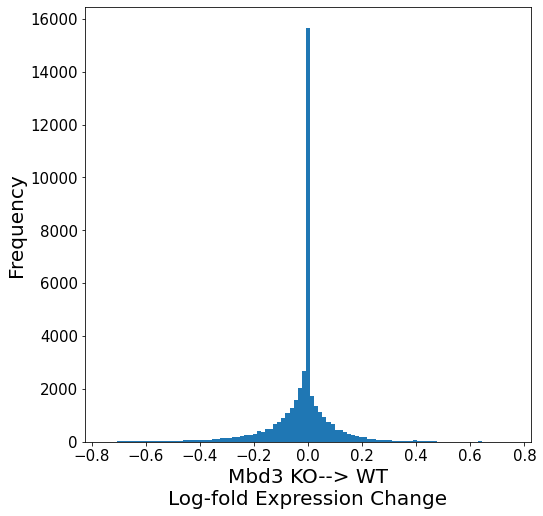

In [14]:
fig, ax = plt.subplots(1, figsize = (8,8))
lim = 0.75
numbins = 100
h = ax.hist(x, bins = np.linspace(-lim,lim,numbins))
ax.set_ylabel('Frequency',size = 20)
ax.set_xlabel('Mbd3 KO--> WT\nLog-fold Expression Change', size = 20)
ax.tick_params(labelsize = 15)

In [15]:
idx = np.argmax(h[0])
h[1][idx:idx+2]

array([-0.00757576,  0.00757576])

In [16]:
h[0][idx]/np.sum(h[0])

0.379006701018458

In [20]:
np.sum(h[0][abs(h[1][:-1])>0.3])/np.sum(h[0])

0.04751191426566998